# Introducción al Modelo de Regresión Lineal con Descenso de Gradiente

Este cuaderno de Colab te guiará a través de una implementación práctica de un modelo de **Regresión Lineal** utilizando el algoritmo fundamental de optimización: el **Descenso de Gradiente**.

A lo largo de este ejemplo, exploraremos los siguientes pasos clave:

1.  **Carga y Exploración de Datos**: Comenzaremos seleccionando y cargando un conjunto de datos apropiado para problemas de regresión lineal. Específicamente, utilizaremos el popular conjunto de datos de **precios de viviendas de California** (`fetch_california_housing`) de la biblioteca `scikit-learn` para demostrar cómo se estructura y se presenta la información con `pandas`.

2.  **Preparación del Conjunto de Datos**: Aprenderás a dividir el dataset cargado en conjuntos de **entrenamiento** y **prueba**. Esta división es crucial para poder evaluar de manera imparcial el rendimiento de nuestro modelo en datos que nunca ha visto, asegurando su capacidad de generalización a nuevas observaciones.

3.  **Implementación del Descenso de Gradiente**: Nos sumergiremos en la parte central del aprendizaje automático: la implementación del algoritmo de Descenso de Gradiente. Aquí definiremos las funciones esenciales:
    * La **función de costo**, que cuantifica el error de nuestras predicciones.
    * La **función de gradiente**, que nos indica la dirección óptima para ajustar los parámetros del modelo.
    Con estas bases, construiremos el bucle iterativo del Descenso de Gradiente para ajustar los parámetros de nuestra regresión lineal y minimizar el error del modelo.

Al finalizar este cuaderno, habrás obtenido una comprensión práctica y visual de cómo el Descenso de Gradiente permite a los modelos de regresión lineal "aprender" de los datos y optimizar sus predicciones.

## Cargar los datos

### Subtask:
Seleccionar un dataset apropiado para regresión lineal y cargarlo en un DataFrame de pandas.


**Reasoning**:
Load the Boston dataset from scikit-learn and create a pandas DataFrame from it, then display the head and info to inspect the data.



In [6]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

# Cargar el dataset de California Housing
california_housing = fetch_california_housing(as_frame=True)
housing_df = california_housing.frame

# Mostrar las primeras filas y la información del DataFrame
display(housing_df.head())
display(housing_df.info())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None

Este es el formato Markdown para Colab que puedes usar para explicar el resultado de la división de tus datos:

```markdown
## Explicación de la División de los Datos

Cuando trabajamos con modelos de aprendizaje automático, es una práctica estándar dividir el dataset disponible en dos o más subconjuntos. Esto se hace para asegurar que podemos evaluar de manera imparcial el rendimiento de nuestro modelo.

Aquí la explicación de los tamaños mostrados:

* **`Tamaño del conjunto de entrenamiento: (16512, 8)`**
    * Esta es la porción de tus datos que el modelo utilizará para **aprender** los patrones y relaciones subyacentes.
    * Significa que tienes `16,512` **filas** (o ejemplos individuales) y `8` **columnas** (que representan las características o variables de entrada).
    * El modelo ajustará sus parámetros (pesos y sesgos) basándose exclusivamente en estos `16,512` ejemplos.

* **`Tamaño del conjunto de prueba: (4128, 8)`**
    * Esta es la porción de tus datos que se **reserva** y no se utiliza durante la fase de entrenamiento.
    * Su propósito principal es **evaluar** qué tan bien el modelo entrenado puede generalizar a datos nuevos y no vistos.
    * Significa que tienes `4,128` **filas** (ejemplos) y `8` **columnas** (características) en este conjunto.
    * Al probar el modelo con estos datos no vistos, obtenemos una medida más realista de su rendimiento y su capacidad para hacer predicciones precisas en situaciones del mundo real.

En este caso, la división se realizó con `test_size=0.2`, lo que significa que el 20% del dataset total fue asignado al conjunto de prueba y el 80% al de entrenamiento. El `random_state=42` se utiliza para asegurar que la división sea siempre la misma cada vez que ejecutes el código, garantizando la **reproducibilidad** de tus resultados.
```

In [7]:
from sklearn.model_selection import train_test_split

# Separar características (X) y variable objetivo (y)
X = housing_df.drop('MedHouseVal', axis=1)
y = housing_df['MedHouseVal']

# Dividir los datos en conjuntos de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (16512, 8)
Tamaño del conjunto de prueba: (4128, 8)


## Implementar la Regresión Lineal con Descenso de Gradiente

### Subtask:
Definir las funciones de costo y gradiente, e implementar el algoritmo de descenso de gradiente.

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Añadir una columna de unos a X_train para el término de intercepto
# Escalar las características antes de añadir la columna de unos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_b = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_b = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]


# Función de costo (MSE)
def cost_function_lr(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/m) * np.sum((predictions - y)**2)
    return cost

# Función para calcular los gradientes
def gradient_lr(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    errors = predictions - y
    # Asegurarse de que X.T.dot(errors) no genere overflow con floats de 64 bits
    gradient = (2/m) * X.T.dot(errors.astype(np.float64))
    return gradient

# Algoritmo de Descenso de Gradiente
def gradient_descent(X, y, theta, learning_rate, epochs):
    cost_history = []
    theta_history = []

    for i in range(epochs):
        gradient = gradient_lr(X, y, theta)
        theta = theta - learning_rate * gradient
        cost = cost_function_lr(X, y, theta)
        cost_history.append(cost)
        theta_history.append(theta.copy()) # Guardar una copia del vector theta
        # Opcional: Imprimir el costo cada cierto número de épocas para monitorear
        # if (i+1) % 100 == 0:
        #     print(f"Época {i+1}, Costo: {cost:.4f}")


    return theta, cost_history, theta_history

# Inicialización de parámetros (theta: [intercepto, coef_MedInc, coef_HouseAge, ...])
# El número de parámetros es igual al número de características + 1 (para el intercepto)
theta_initial = np.zeros(X_train_b.shape[1])

# Parámetros del Descenso de Gradiente
# Reducir la tasa de aprendizaje significativamente
learning_rate_practical = 0.001 # Tasa de aprendizaje reducida
epochs_practical = 5000      # Aumentar épocas para asegurar convergencia

# Entrenar el modelo
theta_final, cost_history_practical, theta_history_practical = gradient_descent(X_train_b, y_train, theta_initial, learning_rate_practical, epochs_practical)

print("Parámetros finales (theta):", theta_final)
print("Costo final (MSE) en el conjunto de entrenamiento:", cost_history_practical[-1])

Parámetros finales (theta): [ 2.07185381  0.82892013  0.17853858 -0.13788115  0.15662019  0.01681474
 -0.04522777 -0.48697734 -0.45138865]
Costo final (MSE) en el conjunto de entrenamiento: 0.5476926327960081


## Parámetros Finales del Modelo y Costo de Entrenamiento

Después de ejecutar el algoritmo de Descenso de Gradiente durante las `5000` épocas especificadas con una tasa de aprendizaje de `0.001`, el modelo de regresión lineal ha ajustado sus parámetros para minimizar la función de costo (MSE).

Aquí se muestran los resultados obtenidos:

* **`Parámetros finales (theta): [ 2.07185381 0.82892013 0.17853858 -0.13788115 0.15662019 0.01681474 -0.04522777 -0.48697734 -0.45138865]`**
    * Este vector `theta` representa los coeficientes (pesos) que el modelo ha aprendido para cada una de las 8 características de entrada, además del término de intercepto.
    * El primer valor (`2.07185381`) corresponde al **intercepto** (el valor predicho cuando todas las características son cero, después del escalado).
    * Los valores subsiguientes (`0.82892013`, `0.17853858`, etc.) son los **coeficientes** asignados a cada una de las 8 características escaladas del dataset de California Housing. Estos coeficientes indican la importancia y la dirección (positiva o negativa) de la relación de cada característica con la variable objetivo (el valor medio de la casa).

* **`Costo final (MSE) en el conjunto de entrenamiento: 0.5476926327960081`**
    * Este valor es el **Error Cuadrático Medio (MSE)** calculado sobre el **conjunto de entrenamiento** después de que el Descenso de Gradiente completó todas sus épocas.
    * Un valor de `0.5477` (redondeando) significa que, en promedio, el cuadrado de la diferencia entre el valor predicho del modelo y el valor real en el conjunto de entrenamiento es aproximadamente `0.5477`. Este es el valor mínimo que el algoritmo pudo alcanzar para la función de costo con los hiperparámetros dados.

Estos resultados nos dan una idea de los parámetros que el modelo ha ajustado para aprender de los datos de entrenamiento y el nivel de error que ha logrado minimizar en ese conjunto. El siguiente paso crucial sería evaluar el modelo en el conjunto de prueba para verificar su capacidad de generalización.

## Visualizar los resultados

### Subtask:
Visualizar el historial del costo (MSE) durante el entrenamiento.

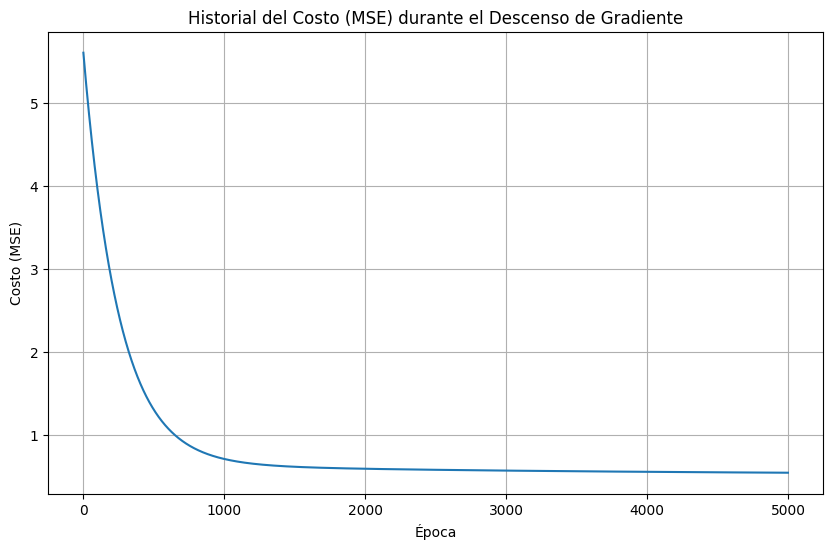

In [10]:
import matplotlib.pyplot as plt

# Gráfica del Historial del Costo (MSE)
plt.figure(figsize=(10, 6))
plt.plot(range(epochs_practical), cost_history_practical, linestyle='-')
plt.title('Historial del Costo (MSE) durante el Descenso de Gradiente')
plt.xlabel('Época')
plt.ylabel('Costo (MSE)')
plt.grid(True)
plt.show()

## Historial del Costo (MSE) durante el Descenso de Gradiente

Esta gráfica es una visualización crucial del proceso de entrenamiento de nuestro modelo de regresión lineal. Muestra cómo la **función de costo (MSE)** cambia a medida que el algoritmo de Descenso de Gradiente itera a lo largo de las épocas.

* **Eje X (Época)**: Representa el número de iteraciones o pasos que el algoritmo ha realizado para ajustar los parámetros del modelo. En este caso, la gráfica muestra hasta 5000 épocas.
* **Eje Y (Costo (MSE))**: Muestra el valor del Error Cuadrático Medio (MSE) en cada época. Recuerda que el MSE cuantifica la diferencia entre las predicciones del modelo y los valores reales; un valor menor indica un mejor rendimiento.

**Interpretación de la Gráfica:**

Observamos una curva que **disminuye rápidamente** al principio y luego se va **aplanando** a medida que avanza el número de épocas.

* **Descenso Rápido Inicial**: Esto indica que en las primeras épocas, el modelo estaba cometiendo muchos errores y, por lo tanto, la función de costo era alta. El Descenso de Gradiente hizo ajustes significativos a los parámetros, lo que resultó en una reducción drástica del MSE.
* **Aplanamiento de la Curva (Convergencia)**: A medida que el número de épocas aumenta (alrededor de las 1000-1500 épocas en este gráfico), la curva de costo se vuelve casi horizontal. Esto significa que el algoritmo se está acercando al **mínimo local (o global, en este caso, al ser regresión lineal)** de la función de costo. Los ajustes de los parámetros se vuelven cada vez más pequeños, ya que el modelo ya está muy cerca de la configuración óptima para los datos de entrenamiento.

En resumen, esta gráfica demuestra visualmente cómo el algoritmo de Descenso de Gradiente trabaja eficazmente para **minimizar el error** del modelo a lo largo del tiempo de entrenamiento, logrando que converja a un punto donde el costo es lo más bajo posible para los datos proporcionados.